In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot 
import awkward as ak
import mplhep as hep
from tqdm import tqdm, trange
from pathlib import Path
hep.styles.use("ROOT")

In [2]:
laserball_data_directory = Path('/nfs/disk1/eos/water_fill/deployed_source/laserball/')
rootfiles = list(laserball_data_directory.glob('*/*.root'))
print(f"Found {len(rootfiles)} files")

def get_rootfile_for_run(run_num):
    for f in rootfiles:
        if f"run{run_num}" in f.as_posix():
            return f

Found 54 files


In [43]:
run_number = 149
laserball_pos = np.array([0, 0, 0])

rootfile = uproot.open(get_rootfile_for_run(run_number))
meta = rootfile.get('meta')
events = rootfile.get('events')
channel_info = rootfile.get('channel_info')

In [44]:
# Accumulate information by LCN Number
def flat_numpy_array(entry):
    return ak.to_numpy(ak.flatten(entry.array()))

from CABLE_DELAYS import CABLE_DELAYS
CABLE_DELAYS = np.asarray(CABLE_DELAYS)

n = 1.342 # water at 425 nm
c = 299.792 # in mm / ns
v_water = c/n # speed of 425 nm light in water

pmtx = ak.to_numpy(meta['pmtx'].array()[0])
pmty = ak.to_numpy(meta['pmty'].array()[0])
pmtz = ak.to_numpy(meta['pmtz'].array()[0])
pmt_pos = np.array([pmtx, pmty, pmtz]).T

time_of_flight = np.linalg.norm(pmt_pos - laserball_pos[np.newaxis, :], axis=-1) / v_water

all_channel = flat_numpy_array(events['channel'])
all_board = flat_numpy_array(events['board'])
all_lcn = flat_numpy_array(events['lcn'])
all_time = flat_numpy_array(events['time'])
all_channel15_time = flat_numpy_array(events['channel15_time'])
all_pedestal_time = flat_numpy_array(events['pedestal'])
all_charge_time = flat_numpy_array(events['charge'])
all_charge_short_time = flat_numpy_array(events['charge_short'])
all_ncrossings = flat_numpy_array(events['ncrossings'])
all_pulse_height = flat_numpy_array(events['pulse_height'])
all_fitted_time = flat_numpy_array(events['fitted_time'])
num_events = len(events['nhit'].array(library='numpy'))

all_time -= (CABLE_DELAYS[all_lcn] + time_of_flight[all_lcn])
all_fitted_time -= (CABLE_DELAYS[all_lcn] + time_of_flight[all_lcn])

[]

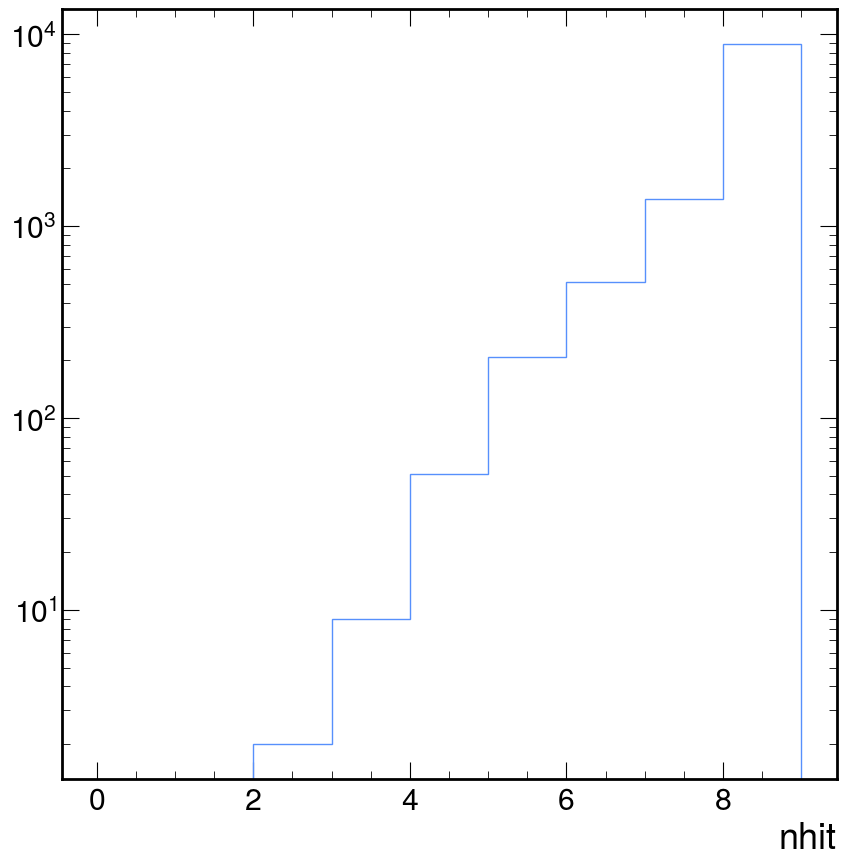

In [39]:
plt.hist(events['nhit'].array(), bins=np.arange(10), histtype='step')
plt.xlabel("nhit")
plt.semilogy()

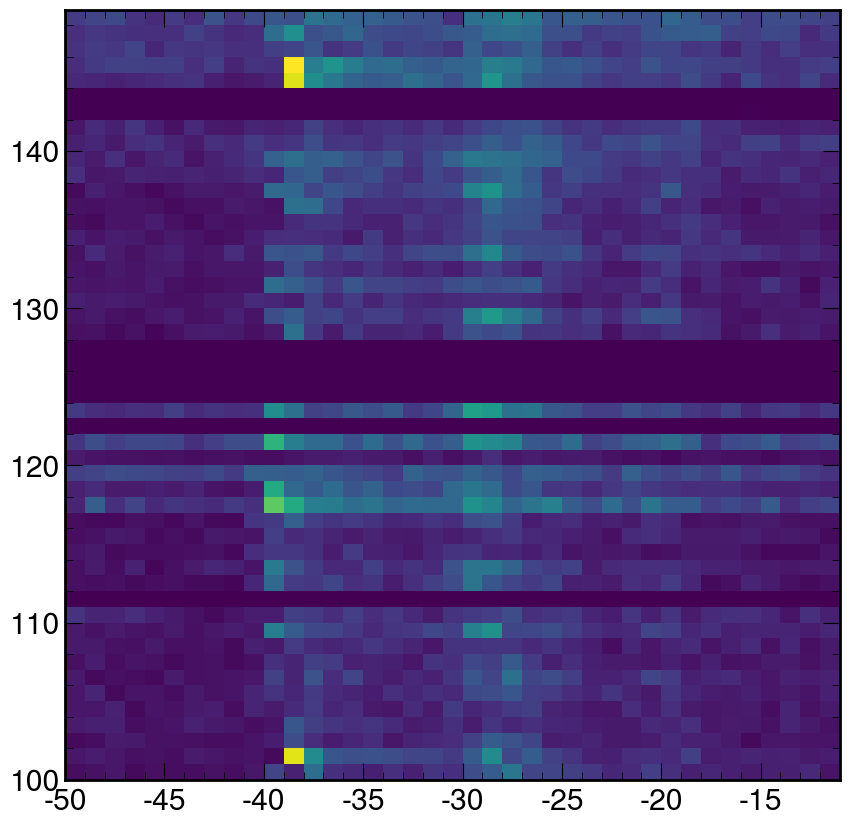

In [70]:
plt.hist2d(all_fitted_time, all_lcn, bins=(np.arange(-50, -10), np.arange(100, 150)))
# plt.hist(all_fitted_time, bins=np.arange(-20, 50))
plt.show()

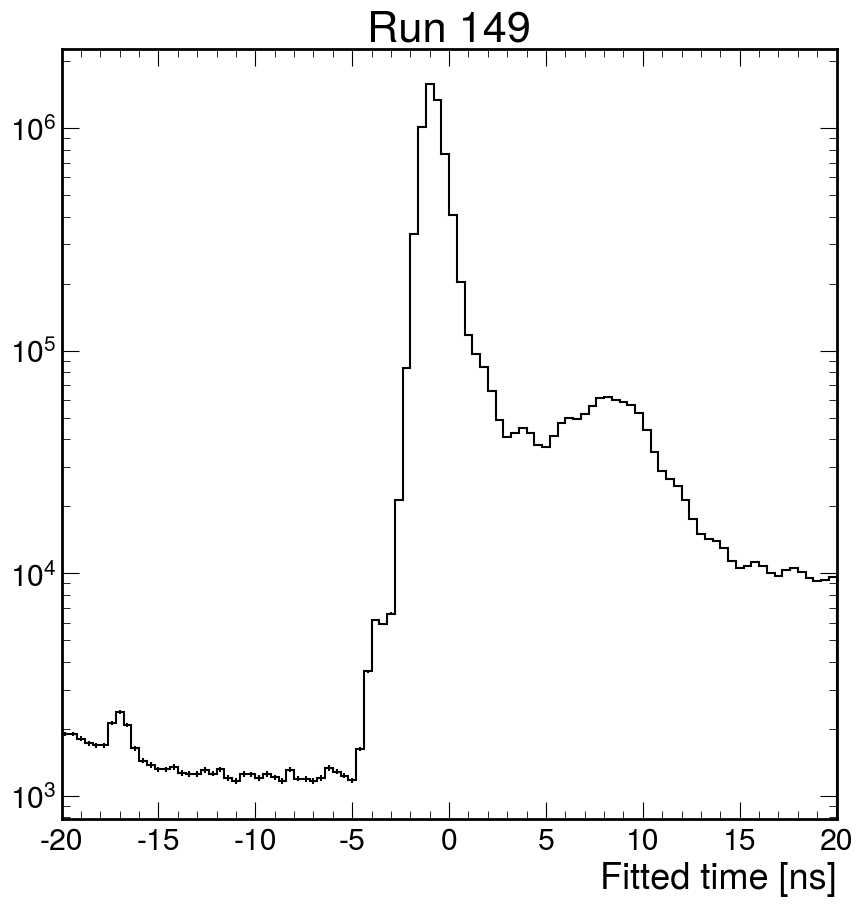

In [66]:
# all_fitted_time_corrected = all_fitted_time + 16 * (all_channel15_time<114)

bad_hit_mask = np.logical_and(all_fitted_time < 9000, all_channel15_time<113)
bad_hit_mask = np.logical_and(bad_hit_mask, all_channel15_time > 110)
bad_hit_mask = np.logical_and(bad_hit_mask, all_board == 4)
all_fitted_time_corrected = np.array(all_fitted_time, copy=True)
all_fitted_time_corrected[bad_hit_mask] += 1e9/62.5e6 # Shift by 1 tick
hep.histplot(np.histogram(all_fitted_time_corrected, bins=100, range=(-20, 20)), yerr=True, color='k')
plt.semilogy()
plt.xlabel("Fitted time [ns]")
plt.title(f"Run {run_number}")
plt.xlim(-20, 20)
plt.show()

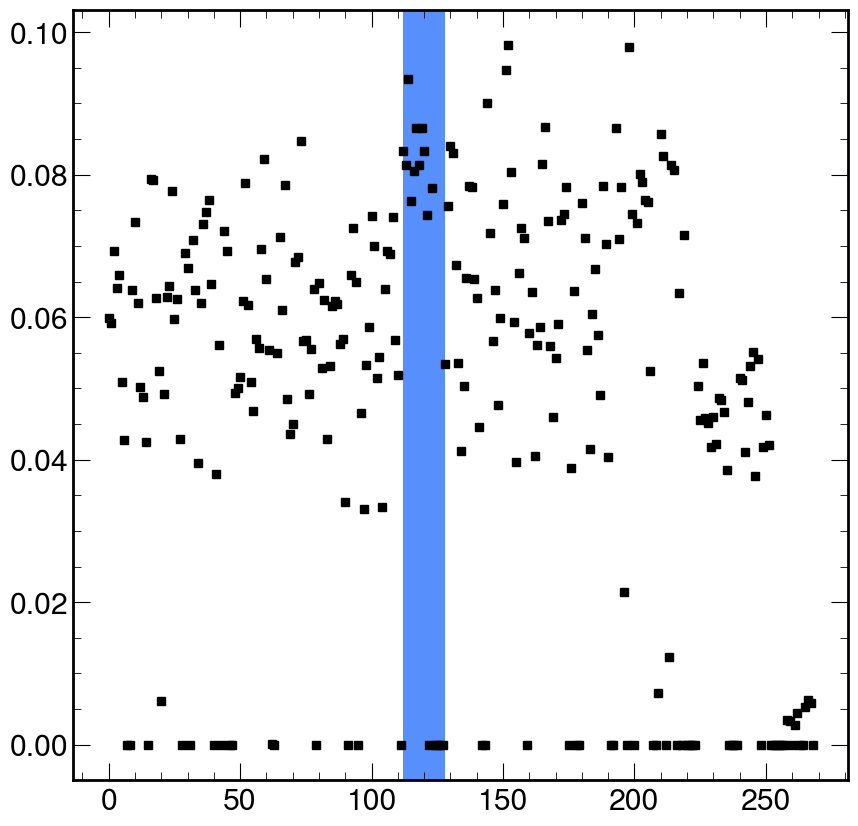

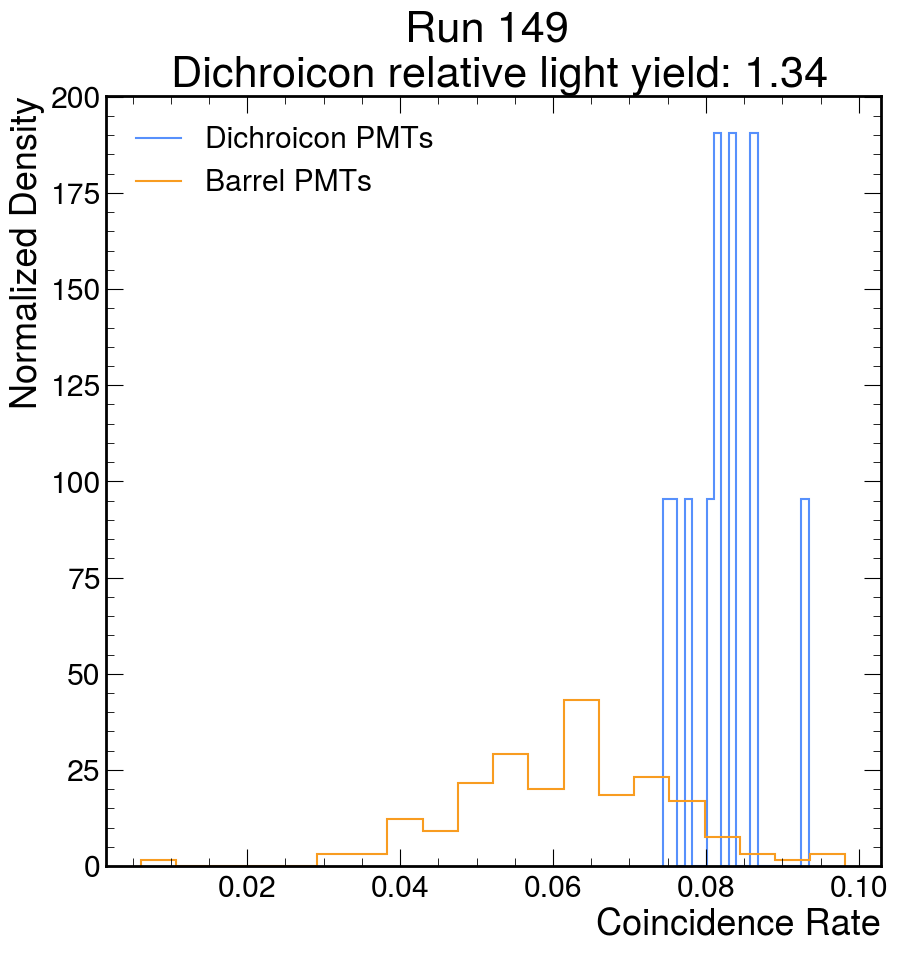

In [41]:
# Compute average nhit for each channel
# Assume single PE -- laser ball is low intensity enough that this is probably ok.
prompt_cut_min = -5
prompt_cut_max = 5

logan_badchannels = [7, 15, 28, 31, 40, 46, 47, 63, 79, 91, 95, 111, 122, 124, 125, 126, 127, 142, 143, 159, 175, 178, 179, 191, 192, 197, 200, 207, 208, 212, 216, 218, 220, 221, 222, 223, 236, 237, 238, 239, 252, 253, 254, 255, 256, 257, 260, 263, 264, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
coincidence_rate_cut = 0.001
max_lcn = np.max(all_lcn)
lcns = np.arange(max_lcn+1)
nhit_per_channel = np.zeros(max_lcn+1)
for lcn in range(max_lcn+1):
    if lcn in logan_badchannels: continue
    all_hits_for_channel = all_fitted_time_corrected[all_lcn == lcn]
    nhit_per_channel[lcn] = len(all_hits_for_channel[(all_hits_for_channel > prompt_cut_min) & (all_hits_for_channel < prompt_cut_max)])
# nhit_per_channel[nhit_per_channel < 2] = np.nan
plt.plot(lcns, nhit_per_channel/num_events, 'ks')
plt.axvspan(7*16, 8*16)
plt.show()
coincidence_rate = nhit_per_channel / num_events
dichroicon_mask = (lcns // 16 == 7) & (coincidence_rate >= coincidence_rate_cut)
barrel_mask = ((lcns // 16 < 7) | ((lcns // 16 >= 8) & (lcns // 16 <= 10))) & (coincidence_rate >= coincidence_rate_cut)
hep.histplot(np.histogram(coincidence_rate[dichroicon_mask], bins=20),
             label='Dichroicon PMTs', density=True)
hep.histplot(np.histogram(coincidence_rate[barrel_mask], bins=20),
             label='Barrel PMTs', density=True)
plt.xlabel("Coincidence Rate")
plt.ylabel("Normalized Density")
dichroicon_relative_lightyield = np.mean(coincidence_rate[dichroicon_mask]) / np.mean(coincidence_rate[barrel_mask])
plt.title(f"Run {run_number} \n Dichroicon relative light yield: {dichroicon_relative_lightyield:.2f}")
plt.legend()

In [42]:
barrel_pmt_nhits = []
dichroicon_pmt_nhits = []
for lcn, ncrossing in enumerate(ncrossing_per_channel):
    board_id = lcn // 16
    if board_id < 7:
        barrel_pmt_nhits.append(ncrossing)
    elif board_id == 7:
        dichroicon_pmt_nhits.append(ncrossing)

barrel_pmt_nhits = np.asarray(barrel_pmt_nhits)
barrel_pmt_nhits = barrel_pmt_nhits[barrel_pmt_nhits > 20]
dichroicon_pmt_nhits = np.asarray(dichroicon_pmt_nhits)
dichroicon_pmt_nhits = dichroicon_pmt_nhits[dichroicon_pmt_nhits > 20]
plt.figure(figsize=(14, 8))
hep.histplot(np.histogram(barrel_pmt_nhits, bins=10, range=(0, 2000)),
             density=True, yerr=True, color='r',
             label=f"Barrel PMTs, Mean = {np.mean(barrel_pmt_nhits):.2f}, Std = {np.std(barrel_pmt_nhits):.2f}")
hep.histplot(np.histogram(dichroicon_pmt_nhits, bins=10, range=(0, 2000)),
             density=True, yerr=True, color='b',
             label=f"Dichroic PMTs, Mean = {np.mean(dichroicon_pmt_nhits):.2f}, Std = {np.std(dichroicon_pmt_nhits):.2f}")
plt.xlabel('NCrossings')
plt.title("Run 46")
plt.legend()

NameError: name 'ncrossing_per_channel' is not defined

In [ ]:
hep.histplot(np.histogram(all_ncrossings[all_board==7], bins=np.arange(10)), density=True)
hep.histplot(np.histogram(all_ncrossings[all_board<7], bins=np.arange(10)), density=True)